# Homework 6 - Implementing k-means with Text Data

### Coding Portion on EdStem and Concept on Gradescope

In this assignment you will implement the k-means algorithm in the specific setting of clustering text documents, but the algorithm is general to any setting. When properly executed, clustering uncovers valuable insights from a set of unlabeled documents. The assignment uses the `numpy` library for manipulating the data arrays. See [this tutorial](https://numpy.org/doc/stable/user/quickstart.html) for more information on numpy.

In this assignment, you will practice:

* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

Fill in the cells provided marked `TODO` with code to answer the questions. **Unless otherwise noted, every answer you submit should have code that clearly shows the answer in the output.** Answers submitted that do not have associated code that shows the answer may not be accepted for credit. 

**Make sure to restart the kernel and run all cells** (especially before turning it in) to make sure your code runs correctly. Answer the questions on Gradescope and make sure to download this file once you've finished the assignment and upload it to Canvas as well.

> Copyright ©2021 Emily Fox and Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Autumn Quarter 2021 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix

%matplotlib inline

# Load data, Extract features

In [4]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Mauno_J%C3%A4rvel...,Mauno J%C3%A4rvel%C3%A4,mauno jrvel born 25 november 1949 in kaustinen...
1,<http://dbpedia.org/resource/David_W._Jourdan>,David W. Jourdan,david walter jourdan born december 5 1954 is a...
2,<http://dbpedia.org/resource/Patrick_Roach>,Patrick Roach,patrick roach born march 4 1969 is a canadian ...
3,<http://dbpedia.org/resource/Louis_Sauer>,Louis Sauer,louis lou sauer aka louis edward sauer born 19...
4,<http://dbpedia.org/resource/Marty_Keough>,Marty Keough,richard martin keough born april 14 1934 in oa...


To work with text data, we must first convert the documents into numerical features. Like Assignment 3, let's extract TF-IDF features for each article.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(wiki['text'])
words = vectorizer.get_feature_names()

Since most documents don't contain every word, many of the TF-IDF entries will be 0. Representing the TF-IDF matrix as a `numpy` matrix will require a lot of unnecessary storage to keep track of all those 0. SciPy provides the idea of a "sparse matrix" that only represents the non-zero entries of a matrix to save space. Externally, you treat it just like a numpy `matrix` but it takes up less storage.

In [93]:
tf_idf = csr_matrix(tf_idf)

tf_idf.shape

(5907, 112801)

The above matrix contains a TF-IDF score for each of the 5907 pages in the data set and each of the 112801 unique words. You can treat it like any matrix of data but internally it is space-efficient since it knows not to store the zero word counts.

# Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

---

### Optional: Justification
This section has some optional background material as to why normalizing makes sense here. You can skip down to the next line break if you don't want to read this.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:

$$\begin{align*}
\|\mathbf{x} - \mathbf{y}\|_2^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y}) & \text{(def of L2 norm)}\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y}) & \text{(FOIL expression)}\\
                              &= \|\mathbf{x}\|_2^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|_2^2 & \text{(def of L2 norm)}\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y}) & \text{($\mathbf{x}$ and $\mathbf{y}$ are length 1)}\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|_2\|\mathbf{y}\|_2}\right) & \text{(Dividing by 1 doesn't change value)}\\
                              &= 2 \cdot cosine\_distance(\mathbf{x}, \mathbf{y})
\end{align*}$$

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

*End optional section*.

---
We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [94]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)
tf_idf

<5907x112801 sparse matrix of type '<class 'numpy.float64'>'
	with 993501 stored elements in Compressed Sparse Row format>

# Implement k-means

The bulk of this assignment will be implementing k-means. We will tackle it in parts to make it manageable.

First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [95]:
def get_initial_centroids(data, k, seed=None):
    """
    Randomly choose k data points as initial centroids
    """
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
        
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, n).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

### k-means Algorithm
After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid. $$z_i \gets \mathrm{argmin}_j \|\mathbf{\mu}_j - \mathbf{x}_i\|^2$$
2. Revise centroids as the mean of the assigned data points. $$\mathbf{\mu}_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i$$

In pseudocode, we iteratively do the following:
```python
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

## Assigning clusters

How do we implement Step 1 of the main k-means loop above? First we import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [96]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')
print(dist)

[[1.39996239 1.39958932]
 [1.40386156 1.39754968]
 [1.38421176 1.39682604]
 ...
 [1.40562888 1.39024794]
 [1.39673862 1.38306708]
 [1.40872806 1.40250208]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

## 🔍 **Question 1** Computing Distances

To test your understanding of how this code works, in the cell below write practice code that does the following tasks

* Initializes 3 centroids that are the first 3 rows of `tf_idf`
* Compute the distances between all the points in `tf_idf` and the 3 centroids. The result should be a matrix with shape `(5907, 3)`. Store this in a variable called `distances`.
* Use `distances` to find the distance between the row of `tf_idf` with index 430 to the second centroid (index 1). Store this value in a variable called `dist`.

In [97]:
### edTest(test_q1_computing_distances) ###

# TODO Fill out this cell
#Initializing the 3 centroids
centroids = tf_idf[:3,:]
#Computing the distances
distances = pairwise_distances(tf_idf, centroids, metric='euclidean')
#print(distances.shape)
#Distance between the 430th row and the second centroid
dist = distances[430, 1]
#print(dist)

## 🔍 **Question 2** Find closest centroid

Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details. After reading the documentation, in the cell below, write code to produce a 1D array whose $i^{th}$ entry indicates the centroid index that is the closest to the $i^{th}$ data point.

Use the list of distances from the previous question. Following the theme of this case study, we will judge whether the clustering makes sense in the context of document analysis. Save this array as `closest_cluster`.

As a note, it would be very slow to compute if you do not use the `argmin`. If you want your notebook to run in a reasonable amount of time, you will need to use the `argmin` function.

*Hint:* the resulting array should be as long as the number of data points.

In [98]:
### edTest(test_q2_closest_centroid) ###

# TODO Fill out this cell
closest_cluster=np.argmin(distances, axis=1)
print(closest_cluster)

[0 1 2 ... 2 2 2]


## 🔍 **Question 3** Assign Clusters

Now that we have completed components of the Step 1 code, let's put it together in a single function that takes a dataset and centroids and assigns each row to the closest centroid.Now we are ready to fill in the blanks the function `assign_clusters(data, centroids)`. 

In [99]:
### edTest(test_q3_assign_clusters) ###

# TODO Complete this function
def assign_clusters(data, centroids):
    """
    Parameters:  
      - data      - is an np.array of float values of length n.  
      - centroids - is an np.array of float values of length k.

    Returns  
      -  A np.array of length n where the ith index represents which centroid 
         data[i] was assigned to. The assignments range between the values 0, ..., k-1.
    """
    # TODO Implement this function
    return np.argmin(pairwise_distances(data, centroids, metric='euclidean'), axis=1)

# Revising clusters

## Numpy Tutorial
Let's turn to Step 2 of the k-means algorithm, where we compute the new centroids given the current cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing

```python
data[cluster_assignment == 0, :]
```

To develop intuition about filtering, let's look at a small example consisting of 3 data points and 2 clusters.

In [100]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid using the function you wrote before.

In [101]:
cluster_assignment = assign_clusters(data, centroids)
cluster_assignment

array([0, 1, 0])

The expression `cluster_assignment == 1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [102]:
cluster_assignment == 1

array([False,  True, False])

Likewise for cluster 0:

In [103]:
cluster_assignment == 0

array([ True, False,  True])

Instead of indices, we can also put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [104]:
data[cluster_assignment == 1]

array([[0., 0., 0.]])

This makes sense since the vector `[0 0 0]` is closer to the centroid `[0 -0.5 0]` than to the centroid `[0.5 0.5 0]`.

Now let's look at the data points assigned to cluster 0:

In [105]:
data[cluster_assignment == 0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Again, this makes sense since these values are each closer to the centroid `[0.5 0.5 0]` than to `[0 -0.5 0]`.

Given all the data points in a cluster, it only remains to compute the mean. Use [np.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

In the cell below, we first find all the rows that were assigned cluster 0 and then take the average of those vectors to find the new cluster 0 centroid. Notice that the result will be an np.array with 3 elements because that's the dimensionality of the vectors.

In [106]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

## 🔍 **Question 4** Revise Centroids


Now we are ready to fill in the blanks the function `revise_centroids(data, k, cluster_assignment)`. In the cell below, complete the `...` sections to compute the new centroids given the current cluster assignment.

In [107]:
### edTest(test_q4_revise_centroids) ###

# TODO fill in this function
def revise_centroids(data, k, cluster_assignment):
    """
    Parameters:  
      - data               - is an np.array of float values of length n.
      - k                  - number of centroids
      - cluster_assignment - np.array of length n where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the values 0, ..., k-1.

    Returns  
      -  A np.array of length k for the new centroids.
    """
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = np.mean(member_data_points, axis = 0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
        
    new_centroids = np.array(new_centroids)
    return new_centroids

# Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=0}^{k-1} \sum_{i=1:z_i = j}^n \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [108]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    """
    Computes the heterogeneity metric of the data using the given centroids and cluster assignments.
    """
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data point
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances ** 2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

    

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [109]:
print(compute_heterogeneity(data, 2, centroids, cluster_assignment))
cluster_assignment.shape

7.25


(3,)

# 🔍 **Question 5** Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics on each iteration
* Stops if either no assignment changed or we reach a certain number of iterations.

Now we are ready to fill in the blanks the function `kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)`. In the cell below, complete the `...` sections to meet the specification of the function.

In [110]:
### edTest(test_q5_kmeans) ###

# TODO Fill in the blanks
def kmeans(data, k, initial_centroids, max_iter, record_heterogeneity=None, verbose=False):
    """
    This function runs k-means on given data and initial set of centroids.
    
    Parameters:  
      - data                 - is an np.array of float values of length N.
      - k                    - number of centroids
      - initial_centroids    - is an np.array of float values of length k.
      - max_iter             - maximum number of iterations to run the algorithm
      - record_heterogeneity - if provided an empty list, it will compute the heterogeneity 
                               at each iteration and append it to the list. 
                               Defaults to None and won't record heterogeneity.
      - verbose              - set to True to display progress. Defaults to False and won't 
                               display progress.

    Returns  
      - centroids - A np.array of length k for the centroids upon termination of the algorithm.
      - cluster_assignment - A np.array of length n where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the 
                             values 0, ..., k-1 upon termination of the algorithm.
    """
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(max_iter):  
        # Print itereation number
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment == cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment - cluster_assignment))
            if verbose:
                print(f'    {num_changed:5d} elements changed their cluster assignment.')  
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [111]:
def plot_heterogeneity(heterogeneity, k):
    """
    Plots how the heterogeneity changes as the number of iterations increases.
    """
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title(f'Heterogeneity of clustering over time, K={k}')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above. We include a seed to ensure everyone gets the same results.

0
1
     2036 elements changed their cluster assignment.
2
      654 elements changed their cluster assignment.
3
      376 elements changed their cluster assignment.
4
      264 elements changed their cluster assignment.
5
      112 elements changed their cluster assignment.
6
       37 elements changed their cluster assignment.
7
       10 elements changed their cluster assignment.
8
        6 elements changed their cluster assignment.
9
        2 elements changed their cluster assignment.
10
        2 elements changed their cluster assignment.
11


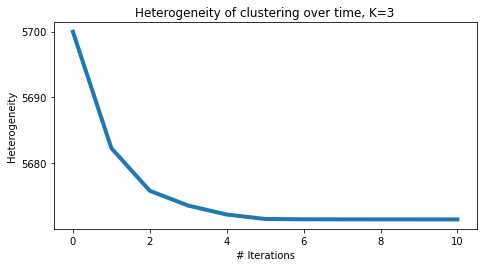

In [112]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, max_iter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

### 🔍 **Question 6** Largest cluster

Using the clustering made in the last cell, write code to computer which cluster contains the most data points. Store your result as a index (an `int`) in a variable named `largest_cluster` 
representing which cluster in `centroids` has the most datapoints assigned to it.


In [113]:
### edTest(test_q6_largest_cluster) ###

# TODO Find largest cluster from example above
largest_cluster = np.argmax(cluster_assignment)

# Beware of Local Minima

One weakness of k-means is that it tends to get stuck in a local minimum based on its starting position. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take a minute or two to run.

In [114]:
%%time
# ^ Magic command to time how long it takes for this cell to run!
# You can see how long it took with the output that says "Wall time"

k = 10
heterogeneity = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, max_iter=800,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(f'seed={seed:06d}, heterogeneity={heterogeneity[seed]:.5f}')


seed=000000, heterogeneity=5569.17352
seed=020000, heterogeneity=5563.93396
seed=040000, heterogeneity=5562.09533
seed=060000, heterogeneity=5574.80813
seed=080000, heterogeneity=5563.38377
seed=100000, heterogeneity=5565.93209
seed=120000, heterogeneity=5572.40064
CPU times: user 3.18 s, sys: 38.9 ms, total: 3.22 s
Wall time: 3.22 s


Notice the variation in heterogeneity for different initializations. This indicates that k-means runs may have not converged or they got stuck at a local minimum.

# k-means++
One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime, but is a bit slower to start since it needs to do more computation to place centroids.

In [115]:
def smart_initialize(data, k, seed=None):
    """
    Use k-means++ to initialize a good set of centroids
    """
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [116]:
%%time

k = 10
heterogeneity_smart = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, max_iter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(f'seed={seed:06d}, heterogeneity={heterogeneity_smart[seed]:.5f}')

seed=000000, heterogeneity=5563.24947
seed=020000, heterogeneity=5569.53006
seed=040000, heterogeneity=5563.95996
seed=060000, heterogeneity=5567.74848
seed=080000, heterogeneity=5557.53663
seed=100000, heterogeneity=5559.45113
seed=120000, heterogeneity=5559.02003
CPU times: user 3.57 s, sys: 28.3 ms, total: 3.6 s
Wall time: 3.6 s


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

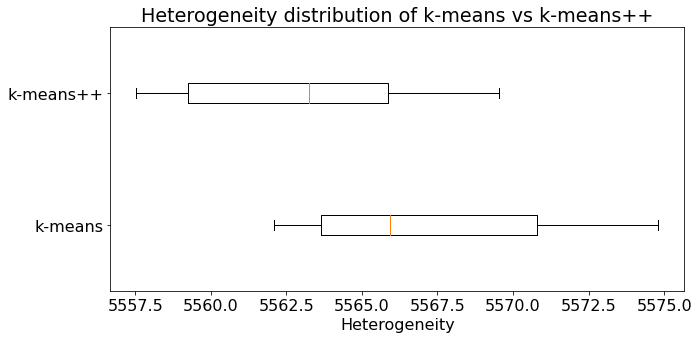

In [117]:
plt.figure(figsize=(10,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)

plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.xlabel('Heterogeneity')
plt.title('Heterogeneity distribution of k-means vs k-means++')

plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* Random initialization results in a worse clustering than k-means++ on average.
* The best result of k-means++ is better than the best result of random initialization.

## 🔍 **Question 7** kmeans_multiple_runs
**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity.

Now we are ready to fill in the blanks the function `kmeans_multiple_runs(data, k, max_iter, verbose=False)`. 



In [118]:
### edTest(test_q7_kmeans_multiple_runs) ###

# TODO Fill in the ...
def kmeans_multiple_runs(data, k, max_iter, seeds, verbose=False):
    """
    Runs kmeans multiple times 
    
    Parameters:  
      - data     - is an np.array of float values of length n.
      - k        - number of centroids
      - max_iter - maximum number of iterations to run the algorithm
      - seeds    - Either number of seeds to try (generated randomly) or a list of seed values
      - verbose  - set to True to display progress. Defaults to False and won't display progress.
    
    Returns  
      - final_centroids          - A np.array of length k for the centroids upon 
                                   termination of the algorithm.
      - final_cluster_assignment - A np.array of length n where the ith index represents which 
                                   centroid data[i] was assigned to. The assignments range between 
                                   the values 0, ..., k-1 upon termination of the algorithm.
    """    
    min_heterogeneity_achieved = float('inf')
    final_centroids = None
    final_cluster_assignment = None
    if type(seeds) == int:
        seeds = np.random.randint(low=0, high=10000, size=seeds)
    
    num_runs = len(seeds)
    
    for seed in seeds:
        # Use k-means++ initialization: Fill in the blank
        # Set record_heterogeneity=None because we will compute that once at the end.
        initial_centroids = smart_initialize(data, k, seed=None)

        # Run k-means: Fill in the blank 
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, max_iter=max_iter, record_heterogeneity=None, verbose=verbose)
        
        # To save time, compute heterogeneity only once in the end
        seed_heterogeneity = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print(f'seed={seed:06d}, heterogeneity={seed_heterogeneity:.5f}')
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if seed_heterogeneity < min_heterogeneity_achieved:
            min_heterogeneity_achieved = seed_heterogeneity
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.


This code block will take some times to complete. It will try 5 values of `k` and for each `k`, will try 3 different seeds. The cell will print its progress to help you know how far it has made. When `k` is larger, it will take longer to run (why might that be?)!

Running k = 2
0
1
      642 elements changed their cluster assignment.
2
      763 elements changed their cluster assignment.
3
       58 elements changed their cluster assignment.
4
        2 elements changed their cluster assignment.
5
seed=020000, heterogeneity=5668.36228
0
1
     1351 elements changed their cluster assignment.
2
      334 elements changed their cluster assignment.
3
      121 elements changed their cluster assignment.
4
       60 elements changed their cluster assignment.
5
       33 elements changed their cluster assignment.
6
       18 elements changed their cluster assignment.
7
       20 elements changed their cluster assignment.
8
       24 elements changed their cluster assignment.
9
       20 elements changed their cluster assignment.
10
       24 elements changed their cluster assignment.
11
       14 elements changed their cluster assignment.
12
       14 elements changed their cluster assignment.
13
       11 elements changed their cluster assignment.
14


     1442 elements changed their cluster assignment.
6
      793 elements changed their cluster assignment.
7
      609 elements changed their cluster assignment.
8
      272 elements changed their cluster assignment.
9
      161 elements changed their cluster assignment.
10
      125 elements changed their cluster assignment.
11
       88 elements changed their cluster assignment.
12
        7 elements changed their cluster assignment.
13
seed=020000, heterogeneity=5483.23626
0
1
    13760 elements changed their cluster assignment.
2
     4623 elements changed their cluster assignment.
3
     2859 elements changed their cluster assignment.
4
     2285 elements changed their cluster assignment.
5
     2120 elements changed their cluster assignment.
6
     1619 elements changed their cluster assignment.
7
     1199 elements changed their cluster assignment.
8
     1043 elements changed their cluster assignment.
9
      884 elements changed their cluster assignment.
10
      698 elements

     8610 elements changed their cluster assignment.
4
     3815 elements changed their cluster assignment.
5
     2536 elements changed their cluster assignment.
6
     2023 elements changed their cluster assignment.
7
     1689 elements changed their cluster assignment.
8
     1225 elements changed their cluster assignment.
9
     1016 elements changed their cluster assignment.
10
     1342 elements changed their cluster assignment.
11
      582 elements changed their cluster assignment.
12
      966 elements changed their cluster assignment.
13
      871 elements changed their cluster assignment.
14
      941 elements changed their cluster assignment.
15
      692 elements changed their cluster assignment.
16
      283 elements changed their cluster assignment.
17
      303 elements changed their cluster assignment.
18
      249 elements changed their cluster assignment.
19
       11 elements changed their cluster assignment.
20
       50 elements changed their cluster assignment.
2

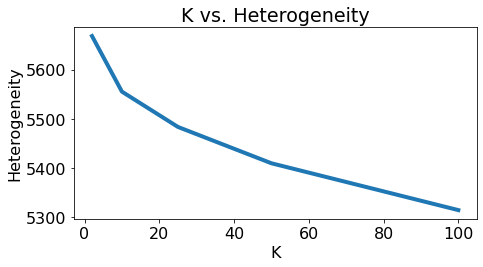

In [119]:
%%time

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    """
    Given list of k-values and their heterogeneities, will make a plot
    showing how heterogeneity varies with k.
    """
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

all_centroids = {}
all_cluster_assignment = {}
heterogeneity_values = []
seeds = [20000, 40000, 80000]
k_list = [2, 10, 25, 50, 100]

for k in k_list:
    print(f'Running k = {k}')
    heterogeneity = []
    all_centroids[k], all_cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, max_iter=400,
                                                                       seeds=seeds, verbose=True)
    score = compute_heterogeneity(tf_idf, k, all_centroids[k], all_cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

# Inspecting clusters of documents
Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [120]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, words, 
                                display_docs=5):
    """
    Given a set of clustered documents, prints information about the centroids including
       - The title and starting sentence of the closest 5 points to each centroid
       - The five words that are contained in the clusters documents with the highest TF-IDF.
    
    Parameters:  
      - wiki: original dataframe
      - tf_idf: data matrix containing TF-IDF vectors for each document
      - centroids: A np.array of length k that contains the centroids for the clustering
      - cluster_assignments: A np.array of length N that has the cluster assignments for each row
      - k: What value of k is used
      - words: List of words in the corpus (should match tf_idf)
      - display_odcs: How many documents to show for each cluster (default 5)
    """
    print('=' * 90)

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print(f'Cluster {c}  ({(cluster_assignment == c).sum()} docs)'),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print(f'{words[idx[i]]}:{centroids[c,idx[i]]:.3f}', end=' '),
        print()
        
        if display_docs > 0:
            print()
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For the nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(display_docs):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print(f'* {wiki.iloc[nearest_neighbors[i]]["name"]:50s} {distances[nearest_neighbors[i]]:.5f}')
                print(f'  {text[:90]}')
                if len(text) > 90:
                    print(f'  {text[90:180]}')
                print()
        print('=' * 90)

Let us first look at the 2 cluster case (K=2).

In [121]:
k = 2
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k, words)

Cluster 0  (4852 docs)
he:0.075 his:0.042 was:0.040 for:0.038 as:0.033 

* Wilson McLean                                      0.94057
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Vipin Sharma                                       0.94801
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Nicky Banger                                       0.95174
  nicholas lee banger born 25 february 1971 is a retired english professional footballer he 
  is currently head of commercial operations with woking fcbanger was born

* Billy Bingham                                      0.95206
  william laurence billy bingham mbe born 5 august 1931 is a former international footballer
   and football manager who now works as a scout for english

* Wally Whitehurst                                   0.95285
  walter

Both clusters have mixed content, although clearly cluster 0 are all women and cluster 1 are all men:

It would be better if we sub-divided into more categories. So let us use more clusters. How about `K=10`?

In [122]:
k = 10
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k, words)

Cluster 0  (619 docs)
he:0.078 university:0.071 research:0.053 at:0.048 professor:0.042 

* Elijah Anderson                                    0.92453
  elijah anderson is an american sociologist he holds the william k lanman jr professorship 
  in sociology at yale university where he teaches and directs the

* Sal Restivo                                        0.92760
  sal restivo born 1940 is a sociologistanthropologist he is a leading contributor to scienc
  e studies and in particular to the sociology of mathematical knowledge his

* Daniel Berg (educator)                             0.93122
  daniel berg is a scientist educator and was the fifteenth president of rensselaer polytech
  nic institutehe was born on june 1 1929 in new york city

* Stuart Henry (criminologist)                       0.93151
  stuart henry is professor of criminal justice and director of the school of public affairs
   san diego state university 2006 he has also been appointed

* Robert Pollack (biologi

We no longer have the clear split between men and women. Cluters 0 and 2 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: notable women
* Cluster 1: baseball players
* Cluster 2: researchers, professors
* Cluster 3: football(soccer)
* Cluster 4: musicians, singers, song writers
* Cluster 5: golfers
* Cluster 6: painters, scultpers, artists
* Cluster 7: orchestral musicians, conductors
* Cluster 8: politicians, political personel
* Cluster 9: film directors|

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of film directors. Increasing the number of clusters may split larger clusters. Another way to look at the size of cluster is to count the number of articles in each cluster.

In [123]:
np.bincount(all_cluster_assignment[10])

array([ 619,  361, 1346,  327,  690,  182,  763,  173,  602,  844])

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.


In [124]:
k = 25
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k,
                            words, display_docs=0) # turn off text for brevity

Cluster 0  (476 docs)
she:0.215 her:0.096 was:0.046 for:0.038 as:0.034 
Cluster 1  (144 docs)
film:0.212 films:0.060 he:0.055 festival:0.050 for:0.045 
Cluster 2  (37 docs)
taylor:0.083 he:0.049 was:0.042 his:0.040 for:0.037 
Cluster 3  (92 docs)
law:0.185 court:0.092 he:0.077 judge:0.070 district:0.052 
Cluster 4  (28 docs)
animation:0.130 animated:0.068 he:0.061 animator:0.055 film:0.054 
Cluster 5  (167 docs)
league:0.138 baseball:0.121 he:0.098 major:0.072 games:0.065 
Cluster 6  (505 docs)
he:0.090 was:0.060 as:0.048 election:0.043 party:0.042 
Cluster 7  (146 docs)
tour:0.112 orchestra:0.105 he:0.087 pga:0.078 music:0.062 
Cluster 8  (96 docs)
racing:0.109 he:0.080 championship:0.071 race:0.062 car:0.054 
Cluster 9  (483 docs)
he:0.076 university:0.072 research:0.059 at:0.048 professor:0.042 
Cluster 10  (258 docs)
published:0.057 book:0.053 he:0.050 novel:0.043 poetry:0.042 
Cluster 11  (65 docs)
economics:0.155 economic:0.094 he:0.088 university:0.077 professor:0.049 
Cluster 1

Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.
* Cluster 0: **British labor party**
* Cluster 1: **Bishops**
* Cluster 2: **danish CEOs**
* Cluster 3: baseball
* Cluster 4: politicials
* Cluster 5: **psychology researchers**
* Cluster 6: **medical researchers**
* Cluster 7: **republican politicians**
* Cluster 8: football(soccer)
* Cluster 9: **prime ministers**
* Cluster 10: golfers
* Cluster 11: coaches
* Cluster 12: **lawers**
* Cluster 13: researchers, professors
* Cluster 14: writers
* Cluster 15: artists, museaum workers
* Cluster 16: film directors
* Cluster 17: musicians
* Cluster 18: **airforce commanders**
* Cluster 19: orchestral musicians
* Cluster 20: *unclear*
* Cluster 21: *unclear*
* Cluster 22: *unclear*
* Cluster 23: politicians
* Cluster 24: **hockey players**

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [125]:
k = 100
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k,
                            words, display_docs=0)

Cluster 0  (2 docs)
stearns:0.318 hombs:0.222 homelessness:0.137 yoho:0.133 washington:0.122 
Cluster 1  (18 docs)
jersey:0.210 new:0.091 assembly:0.064 state:0.058 he:0.058 
Cluster 2  (38 docs)
law:0.303 legal:0.089 he:0.074 school:0.054 university:0.050 
Cluster 3  (10 docs)
comedy:0.254 standup:0.172 show:0.107 comedian:0.089 orben:0.069 
Cluster 4  (56 docs)
hockey:0.253 nhl:0.117 season:0.086 ice:0.086 he:0.076 
Cluster 5  (38 docs)
bbc:0.192 television:0.066 he:0.063 for:0.062 radio:0.055 
Cluster 6  (45 docs)
she:0.262 her:0.127 baseball:0.063 was:0.051 girls:0.041 
Cluster 7  (118 docs)
he:0.072 university:0.062 research:0.050 at:0.041 society:0.037 
Cluster 8  (32 docs)
theatre:0.268 play:0.057 directed:0.056 at:0.055 plays:0.047 
Cluster 9  (8 docs)
war:0.117 communist:0.073 yugoslavia:0.068 victims:0.065 his:0.063 
Cluster 10  (121 docs)
art:0.190 museum:0.100 gallery:0.070 he:0.053 his:0.049 
Cluster 11  (37 docs)
opera:0.317 she:0.073 at:0.048 with:0.046 he:0.043 
Cluster

music:0.125 he:0.075 jazz:0.066 piano:0.052 with:0.051 
Cluster 53  (67 docs)
minister:0.198 he:0.090 was:0.064 prime:0.062 as:0.052 
Cluster 54  (4 docs)
gyllenhammar:0.151 exhibition:0.148 sweden:0.140 stockholm:0.125 her:0.121 
Cluster 55  (30 docs)
photography:0.076 photographer:0.061 he:0.058 fashion:0.054 his:0.051 
Cluster 56  (24 docs)
band:0.129 drummer:0.083 rock:0.068 metal:0.058 bands:0.057 
Cluster 57  (36 docs)
digital:0.071 entertainment:0.059 media:0.058 he:0.048 executive:0.042 
Cluster 58  (16 docs)
water:0.132 he:0.056 polo:0.053 his:0.038 hay:0.035 
Cluster 59  (67 docs)
album:0.156 her:0.149 she:0.101 released:0.068 on:0.051 
Cluster 60  (142 docs)
he:0.084 court:0.055 was:0.054 law:0.053 from:0.052 
Cluster 61  (42 docs)
she:0.161 series:0.108 role:0.069 her:0.065 episode:0.056 
Cluster 62  (104 docs)
she:0.165 her:0.150 film:0.066 actress:0.061 for:0.048 
Cluster 63  (13 docs)
referee:0.218 fifa:0.106 refereeing:0.080 he:0.080 uefa:0.073 
Cluster 64  (118 docs)
b

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Scotland, Brazil, LGBT, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows.  Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

## 🔍 **Question 8** Small clusters

Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). When doing k-means with k=100, how many of the clusters have fewer than 44 articles (i.e. 0.004% of the dataset)?

Save your result in a variable called `num_small_clustesrs`


In [126]:
### edTest(test_q8_small_clusters) ###

# TODO count clusters with fewer than 44 articles
centroids, cluster_assignment = kmeans(tf_idf, 100, smart_initialize(tf_idf, 100), max_iter=400, record_heterogeneity=None, verbose=False)
num_small_clusters = np.sum(np.bincount(cluster_assignment) < 44)
print(num_small_clusters)

54


Keep in mind though that tiny clusters aren't necessarily bad. A tiny cluster of documents that really look like each others is definitely preferable to a medium-sized cluster of documents with mixed content. However, having too few articles in a cluster may lead us to question if that cluster is really worth separating from the others.